<a href="https://colab.research.google.com/github/SaraKmair/Quora-Question-Pairs/blob/master/QuoraQuestionPairs_InitialResult.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upload csv file from Google Drive

In [0]:
# read csv file from google drive into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
import pandas as pd

In [0]:
link = 'https://drive.google.com/open?id=1yuw8KRR_y8e6wY3py9Y2gM7LmJ6m0X2z' # The shareable link

In [36]:
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1yuw8KRR_y8e6wY3py9Y2gM7LmJ6m0X2z


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('quora_duplicate_questions.tsv')  
df = pd.read_csv('quora_duplicate_questions.tsv', sep="\t")
# Dataset is now stored in a Pandas Dataframe

## EDA

In [38]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
#importing the libraries 
import pandas as pd #for data handeling 
import numpy as np 
import re #for regular expression 
import string 
import seaborn as sns
import nltk #natural language tool kit 
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from nltk import sent_tokenize, word_tokenize
from nltk import corpus
from nltk.stem import PorterStemmer
import difflib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [40]:
df.shape

(404290, 6)

In [41]:
df.dtypes

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object

In [42]:
#checking for Null values 
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [0]:
#remove the missing values 
df = df.dropna().reset_index(drop = True)
df.isnull().sum()
#renaming is_duplicate column
df.rename(columns = {'is_duplicate': 'label'}, inplace = True)


**Meta data** <br />

**Id** a simple rowID. <br />
**qid{1, 2}** The unique ID of each question in the pair. <br />
**question{1, 2}** The actual textual contents of the questions. <br />
**is_duplicate** The label that we are trying to predict - whether the two questions are duplicates of each other. <br />

In [44]:
#check data balance 
(df['label'].value_counts() /len(df.label))*100

0    63.079941
1    36.920059
Name: label, dtype: float64

63% is non-duplicate questions <br />
36.9% is duplicate questions

In [45]:
#exmple of duplicate questions

df.loc[df['label'] == 1].head()

,id,qid1,qid2,question1,question2,label
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


In [46]:
#exmple of non duplicate questions

df.loc[df['label'] == 0].head()

,id,qid1,qid2,question1,question2,label
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0



## Word Count in each question

In [47]:
#word count in each question 
df['count1'] = df['question1'].str.count(' ') + 1
df['count2'] = df['question2'].str.count(' ') + 1
df.head()

,id,qid1,qid2,question1,question2,label,count1,count2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8,13
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14,10
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11,9
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13,7


In [48]:
#check the percentage of questions that are longer than 50 words 
(df[df['count2'] > 50 ].shape[0] / len(df.count2))*100

0.18427503234088655

In [49]:
(df[df['count1'] > 50 ].shape[0] / len(df.count2))*100

0.04699631697284355

In [50]:
df[df['count2']> 50 ]

,id,qid1,qid2,question1,question2,label,count1,count2
1671,1671,3327,3328,What are some interesting differences between ...,Is it weird for a 'hearing' person with no dea...,0,13,53
2395,2395,4761,4762,I emailed my interviewer after the technical i...,I have applied for the Thought Works company t...,0,22,52
2580,2580,5126,5127,Is it a good idea for a CEO to take personal c...,A person I know has an idea for a mobile appli...,0,28,58
2632,2632,5230,5231,I have done a diploma in mechanical engineerin...,I have completed a 1-year diploma in fashion d...,0,22,54
2702,2702,76,5366,My girlfriend said that we should end this bec...,After 2 years being in a relationship my girlf...,0,37,51
...,...,...,...,...,...,...,...,...
402651,402654,536154,536155,Solve this for all masterminds !! ...,Solve this for all masterkminds!! ...,0,65,55
403753,403756,427820,537352,I was fired from my job and my boss didn't giv...,I got fired from my job and today I found out ...,0,32,51
403853,403856,537475,537476,My 10-year-old son is so lazy and irresponsibl...,"My Son, 7 years old, walked into my room cryin...",0,14,53
404061,404064,537695,537696,Are cookies stored on my device even if I have...,I have 10 years of experience in human resourc...,0,25,60


**Common Words**

In [0]:
#check top 50 common words 
freq1 = pd.Series(' '.join(df['question1']).split()).value_counts()[:50]
freq2 = pd.Series(' '.join(df['question2']).split()).value_counts()[:50]

In [0]:
question1 = list(df['question1'])
question2 = list(df['question2'])

In [53]:
#check the percent of invalid questions 
#check for invalid questions 
invalid_questions = []
for i in range(len(question1)):
    # questions need to contain a vowel to be valid 
    if not re.search('[aeiouy]', question1[i]) or not re.search('[aeiouy]', question2[i]):
    # check length the invalid questions to remove them
        invalid_questions.append(i-len(invalid_questions))
print(len(invalid_questions))
len(invalid_questions)/len(question1) 

172


0.0004254403431225837


## DataVisualization

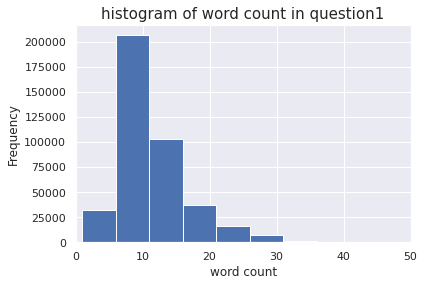

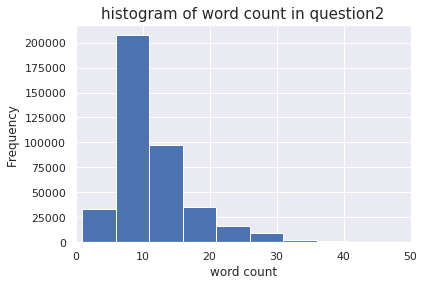

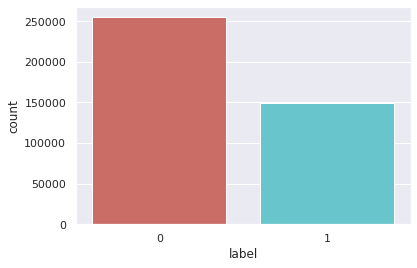

In [54]:
#Histogram of word count 1 & 2
#distribution of wordcount for question 1 

sns.set()
bin_edges = [0,5,20,25,20,25,30,35,40,45,50]
_ = plt.hist(df['count1'], bins=range(min(df['count1']), max(df['count1']) + 5, 5))
_ = plt.xlabel('word count')
_ = plt.ylabel('Frequency')
plt.title('histogram of word count in question1',fontsize=15)
plt.xlim(min(bin_edges), max(bin_edges))
plt.show()

#distribution of wordcount for question 2
sns.set()
bin_edges = [0,5,20,25,20,25,30,35,40,45,50]
_ = plt.hist(df['count2'], bins=range(min(df['count2']), max(df['count2']) + 5, 5))
_ = plt.xlabel('word count')
_ = plt.ylabel('Frequency ')
plt.title('histogram of word count in question2',fontsize=15)
plt.xlim(min(bin_edges), max(bin_edges))

plt.show()

#label count 
sns.countplot(x = 'label', data = df, palette = 'hls')
plt.show()



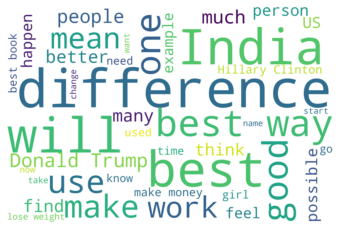

In [55]:
from wordcloud import WordCloud 
freq1_letters = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces as word cloud accept string only 
                          str(question1))
wordcloud=WordCloud(background_color='white',mode="RGB", width=3000 , height=2000, max_words= 40, min_font_size=15).generate(freq1_letters) 
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

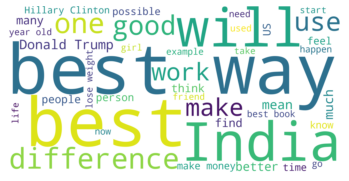

In [56]:
freq2_letters = re.sub("[^a-zA-Z]",  # Search for all non-letters
                          " ",          # Replace all non-letters with spaces as word cloud accept string only 
                          str(question2))
wordcloud=WordCloud(background_color='white',mode="RGB", width=2000 , height=1000, max_words= 40, min_font_size=15).generate(freq2_letters) 
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [0]:
#change data type in count1 and count2 into integer 
df['count1'] = df['count1'].astype(int)
df['count2'] = df['count2'].astype(int)

## Text Pre-processing 
- Drop questions with more than 50 words <br />
- Convert to lower case: will prevent having multiple copies of the same word <br />
- Remove some of the common words <br />
- Remove shortcuts <br />
- Remove puctuations or any other symbols in order to not consider puctuations as words <br />
- Remove stop words <br />
- Remove Numbers <br />
- Remove invalid questions <br />


In [0]:
#remove questions with more than 50 words 
df = df[df['count2']< 50]
df = df[df['count1']< 50]


In [59]:
df.shape

(403285, 8)

In [0]:
#convert all the data frame to lower case 
df_clean = df.apply(lambda x: x.astype(str).str.lower())

In [0]:
#remove common words //in this case I decided to remove the top 50 common words
freq1 = list(freq1.index)
freq2 = list(freq2.index)
df_clean['question1'] = df_clean['question1'].apply(lambda x :" ".join(x for x in x.split()if x not in freq1))
df_clean['question2'] = df_clean['question2'].apply(lambda x :" ".join(x for x in x.split()if x not in freq2))

In [0]:
pd.set_option('display.max_colwidth',100)

In [63]:
df_clean['question1'][2:10]

2                    i increase speed internet connection while using vpn?
3                               why am i mentally very lonely? i solve it?
4    which one dissolve water quikly sugar, salt, methane carbon di oxide?
5         astrology: i am capricorn sun cap moon cap rising...what say me?
6                                                             i buy tiago?
7                                                             i geologist?
8                                                         use シ instead し?
9                    motorola (company): i hack charter motorolla dcx3400?
Name: question1, dtype: object

**Remove Shortcuts** <br />
**Remove Numbers** <br />
**Remove short words**

In [0]:
#replace the shortcuts with words
def clean(s):

    s = re.sub(r"\'ve", " have ", s)
    s = re.sub(r"can't", "cannot ", s)
    s = re.sub(r"n't", " not ", s)
    s = re.sub(r"\'s", " ", s)
    s = re.sub(r"I'm", "I am", s)
    s = re.sub(r" m ", " am ", s)
    s = re.sub(r"\'re", " are ", s)
    s = re.sub(r"\'d", " would ", s)
    s = re.sub(r"\'ll", " will ", s)
    
  #remove numbers
    s = re.sub('[0-9]+', '', s) 

  #remove short words (<3 character)
    s = re.sub(r"\W*\b\w{1,2}\b", "", s)

    return s
df_clean['question1'] = df_clean['question1'].apply(clean)
df_clean['question2'] = df_clean['question2'].apply(clean)

**Remove punctuations**

In [0]:
#remove puctuations 

df_clean['question1'] = df_clean['question1'].str.replace('[^\w\s]','')
df_clean['question2'] = df_clean['question2'].str.replace('[^\w\s]','')

**Remove stop words**

In [66]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-cp36-none-any.whl size=32917 sha256=ab9cab8718c6c3da0aea1df5aed7acee61b11dda4fdb1dd501cdaf908cfe5f23
  Stored in directory: /root/.cache/pip/wheels/75/37/6a/2b295e03bd07290f0da95c3adb9a74ba95fbc333aa8b0c7c78
Successfully built stop-words


In [0]:
from stop_words import get_stop_words
stop_words = get_stop_words('en')
stop_words = get_stop_words('english')

In [0]:
#tokenize the questions and remove stop words 
#remove stop words from question1
df_clean['question1'] = df_clean['question1'].apply(lambda x: [item for item in str.split(x) if item not in stop_words])
#remove stop words from question2 
df_clean['question2'] = df_clean['question2'].apply(lambda x: [item for item in str.split(x) if item not in stop_words])

In [69]:
len(stop_words)

174

In [70]:
df_clean.shape

(403285, 8)

In [71]:
df_clean.head()

,id,qid1,qid2,question1,question2,label,count1,count2
0,0,1,2,"[step, step, guide, invest, share, market, india]","[step, step, guide, invest, share, market]",0,14,12
1,1,3,4,"[story, kohinoor, kohnoor, diamond]","[happen, indian, government, stole, kohinoor, kohnoor, diamond, back]",0,8,13
2,2,5,6,"[increase, speed, internet, connection, using, vpn]","[internet, speed, increased, hacking, dns]",0,14,10
3,3,7,8,"[mentally, lonely, solve]","[find, remainder, mathmath, divided]",0,11,9
4,4,9,10,"[one, dissolve, water, quikly, sugar, salt, methane, carbon, oxide]","[fish, survive, salt, water]",0,13,7


## Text Normalization 

**Stemming**: remove the suffices

In [0]:
#stem the words 
from nltk.stem import SnowballStemmer
st = SnowballStemmer("english")
df_clean['question1'] = df_clean['question1'].apply(lambda x: " ".join([st.stem(word) for word in x]))
df_clean['question2'] = df_clean['question2'].apply(lambda x: " ".join([st.stem(word) for word in x]))

In [0]:
#remove invalid questions 
for index in invalid_questions:
    df_clean = df_clean[df_clean.id != index]
    question1.pop(index)
    question2.pop(index)

In [74]:
df_clean.tail()

,id,qid1,qid2,question1,question2,label,count1,count2
404282,404285,433578,379845,mani keyword racket program languag latest version,mani keyword perl program languag latest version,0,14,13
404283,404286,18840,155606,believ life death,true life death,1,8,9
404284,404287,537928,537929,one coin,coin,0,4,3
404285,404288,537930,537931,approx annual cost live studi uic chicago indian student,littl hairfal problem want use hair style product one prefer gel wax clay,0,17,25
404286,404289,537932,537933,sex cousin,sex cousin,0,8,10


**TF-IDF** <br />
**"term frequency" which is the number of times a word appears in a document** <br>
**TF = (Frequency of the word in the sentence) / (Total number of words in the sentence)** <br>
**IDF: (Total number of sentences (documents))/(Number of sentences (documents) containing the word)**

In [0]:
#encode questions to unicode 
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [0]:
#convert the text to list 
question1 = list(df_clean['question1'])
question2 = list(df_clean['question2'])
questions = question1 + question2 

In [0]:
# get the number of unique words 
def unique_words(x, y):
    unique_word_list = []
    unique_word_cnt = []
    for i in range(len(x)):
        intersection_set = set.intersection(*[set(x[i]), set(y[i])]) #intersection between question1 and question2
        union_set = set.union(*[set(x[i]), set(y[i])]) #union between question1 and question2
        unique_words = union_set - intersection_set #unique words 
        unique_word_list.append(unique_words) #get the unique words list 
        unique_word_cnt.append(len(unique_words)) #get the link of unique words                
    return unique_word_cnt

In [78]:
 df_clean['unique_word_cnt'] = unique_words(question1, question2)
 df_clean[['question1', 'question2', 'count1', 'count2', 'unique_word_cnt', 'label']].head()

,question1,question2,count1,count2,unique_word_cnt,label
0,step step guid invest share market india,step step guid invest share market,14,12,0,0
1,stori kohinoor kohnoor diamond,happen indian govern stole kohinoor kohnoor diamond back,8,13,7,0
2,increas speed internet connect use vpn,internet speed increas hack dns,14,10,5,0
3,mental lone solv,find remaind mathmath divid,11,9,8,0
4,one dissolv water quik sugar salt methan carbon oxid,fish surviv salt water,13,7,11,0


In [0]:
#get the number of common words 
def common_words(x, y):
    common_words = []
    for i in range(len(x)):
        common_ratio = difflib.SequenceMatcher(None, x[i], y[i]).ratio()
        common_words.append(common_ratio)
    return common_words

df_clean['common_words'] = common_words(question1, question2)

In [0]:
#word vectorizer 
tfidf_vectors = TfidfVectorizer(stop_words='english', min_df=10, max_df = 0.5,  sublinear_tf= True,  ngram_range=(1, 1))

In [81]:
tfidf_vectors 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.5, max_features=None,
                min_df=10, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
#create sparse matrix 
tfidf_matrix = tfidf_vectors.fit_transform(questions)


In [0]:
# get features names 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
feature_names = tfidf_vectors.get_feature_names()

In [84]:

df_clean.head()

,id,qid1,qid2,question1,question2,label,count1,count2,unique_word_cnt,common_words
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,14,12,0,0.918919
1,1,3,4,stori kohinoor kohnoor diamond,happen indian govern stole kohinoor kohnoor diamond back,0,8,13,7,0.651163
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dns,0,14,10,5,0.463768
3,3,7,8,mental lone solv,find remaind mathmath divid,0,11,9,8,0.279070
4,4,9,10,one dissolv water quik sugar salt methan carbon oxid,fish surviv salt water,0,13,7,11,0.270270


## Word Embedding

**en_core_web_md**


In [85]:
#install spacy model en_core_web_md
import spacy.cli
spacy.cli.download("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [86]:
#load en_core_web_lg
import spacy 
nlp = spacy.load("en_core_web_md")   
total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 20000


In [0]:
#build word vectors for question1 
word_vecs1 = [doc.vector for doc in nlp.pipe(df['question1'], n_threads = 50)] #this will give the document vector 
word_vecs1 = np.array(word_vecs1)

In [0]:
 #build word vectors for question2 
word_vecs2 = [doc.vector for doc in nlp.pipe(df['question2'], n_threads = 50)] #this will give the document vector 
word_vecs2 = np.array(word_vecs2)


In [89]:
word_vecs1.shape

(403285, 300)

## Dimensionality Reduction

**PCA** <br />
Unsupervise linear dimensionality reduction technique that takes large data dimension and returns lower data dimension by using clustering. it keeps the components with high variance which means we won't lose valuable features. principal component is the output of converting correlated variables to uncorrelated variables. This will also speed up the machine learning algorithm.

In [0]:
#PCA
from sklearn.decomposition import PCA


Number of components = 50 and explained variance = 0.7123203133445924
Number of components = 100 and explained variance = 0.8386462160717931
Number of components = 150 and explained variance = 0.9094021240336004
Number of components = 170 and explained variance = 0.9298971445890261
Number of components = 180 and explained variance = 0.9391287179334604


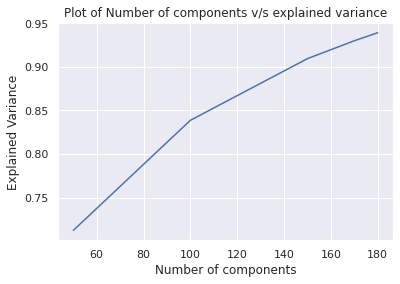

In [91]:
#apply PCA and check the variance 
#the optimal number of components 
n_comp = [50, 100, 150, 170, 180]
explained = [] 
for x in n_comp:
    pca = PCA(n_components=x)
    pca.fit(word_vecs1)
    explained.append(pca.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,pca.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [0]:
pca = PCA(n_components=180)
pca1 = pca.fit_transform(word_vecs1)

In [93]:
pca1.shape

(403285, 180)

Number of components = 50 and explained variance = 0.7125147740291343
Number of components = 100 and explained variance = 0.8384166816104727
Number of components = 150 and explained variance = 0.9092697730370092
Number of components = 170 and explained variance = 0.9299244216298457


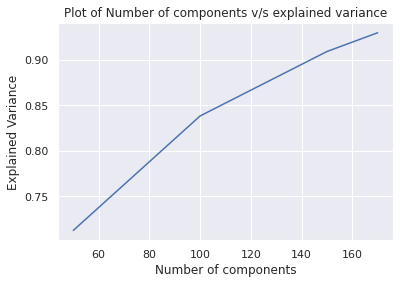

In [94]:
#apply PCA and check the variance 
#the optimal number of components 
n_comp = [50, 100, 150, 170] # list containing different values of components
explained = [] # explained variance ratio for each component of Truncated SVD
for x in n_comp:
    pca = PCA(n_components=x)
    pca.fit(word_vecs1)
    explained.append(pca.explained_variance_ratio_.sum())
    print("Number of components = %r and explained variance = %r"%(x,pca.explained_variance_ratio_.sum()))
plt.plot(n_comp, explained)
plt.xlabel('Number of components')
plt.ylabel("Explained Variance")
plt.title("Plot of Number of components v/s explained variance")
plt.show()

In [0]:
pca = PCA(n_components=180)
pca2 = pca.fit_transform(word_vecs2)

In [96]:
pca2.shape

(403285, 180)

In [97]:
len(pca1)

403285

## Feature Extraction

**Cosine Similarity** <br /> 
Cosine similarity is a metric to measure how similar documents are regardless of their length. it measures the cosine of the angle between two vectors by
looking at their directions (or orientations) without caring about their length 

In [0]:
tfidf_matrix1 = tfidf_matrix[:403285]

In [0]:
tfidf_matrix2 = tfidf_matrix[403285:]

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = []
for i in range(403285):
  tfidf_q1 = tfidf_matrix1[i]
  tfidf_q2 = tfidf_matrix2[i]
  cosine_sim.append(cosine_similarity(tfidf_q1, tfidf_q2)[0][0])

In [101]:
len(cosine_sim)

403285

In [0]:
df_clean['cosine_sim_tfidf'] = cosine_sim[0: len(cosine_sim)]


In [103]:
df_clean.tail()

,id,qid1,qid2,question1,question2,label,count1,count2,unique_word_cnt,common_words,cosine_sim_tfidf
404282,404285,433578,379845,mani keyword racket program languag latest version,mani keyword perl program languag latest version,0,14,13,1,0.918367,0.705006
404283,404286,18840,155606,believ life death,true life death,1,8,9,4,0.750000,0.636499
404284,404287,537928,537929,one coin,coin,0,4,3,2,0.666667,1.000000
404285,404288,537930,537931,approx annual cost live studi uic chicago indian student,littl hairfal problem want use hair style product one prefer gel wax clay,0,17,25,6,0.279070,0.000000
404286,404289,537932,537933,sex cousin,sex cousin,0,8,10,0,1.000000,1.000000


**Euclidean Distance**


In [0]:
from sklearn.metrics.pairwise import euclidean_distances

In [0]:
euc_dist = []
for i in range(403285):
  docvec_q1 = pca1[[i]]
  docvec_q2 = pca2[[i]]
  euc_dist.append(euclidean_distances(docvec_q1, docvec_q2))

In [106]:
euc_dist[0:10]

[array([[1.3299066]], dtype=float32),
 array([[1.4868474]], dtype=float32),
 array([[1.6873087]], dtype=float32),
 array([[2.7604635]], dtype=float32),
 array([[2.3058217]], dtype=float32),
 array([[1.5770429]], dtype=float32),
 array([[2.8480961]], dtype=float32),
 array([[1.386074]], dtype=float32),
 array([[1.775192]], dtype=float32),
 array([[1.774564]], dtype=float32)]

In [0]:
#Normalized Data
#def norm(x):
  #normalized = (x-min(x))/(max(x)-min(x))
  #return normalized

#apply normalization on distance 
#norm_euc_dist = norm(euc_dist)
#convert to list 
euc_dist = np.concatenate(euc_dist, axis=0 )

In [0]:
df_clean['euc_dist'] = euc_dist

**Jaccard Similarity** 

In [0]:
#jaccard similarity 
#apply jaccard similarity on documents vectors 
def jaccard_similarity(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

In [0]:
jaccard_sim = []
for i in range(403285):
  docvec_q1 = pca1[i]
  docvec_q2 = pca2[i]
  jaccard_sim.append(jaccard_similarity(docvec_q1, docvec_q2))

In [111]:
len(jaccard_sim)

403285

In [0]:
df_clean['jac_sim'] = jaccard_sim

In [113]:
df_clean.head()

,id,qid1,qid2,question1,question2,label,count1,count2,unique_word_cnt,common_words,cosine_sim_tfidf,euc_dist,jac_sim
0,0,1,2,step step guid invest share market india,step step guid invest share market,0,14,12,0,0.918919,0.974700,1.329907,0.0
1,1,3,4,stori kohinoor kohnoor diamond,happen indian govern stole kohinoor kohnoor diamond back,0,8,13,7,0.651163,0.645063,1.486847,0.0
2,2,5,6,increas speed internet connect use vpn,internet speed increas hack dns,0,14,10,5,0.463768,0.456422,1.687309,0.0
3,3,7,8,mental lone solv,find remaind mathmath divid,0,11,9,8,0.279070,0.000000,2.760463,0.0
4,4,9,10,one dissolv water quik sugar salt methan carbon oxid,fish surviv salt water,0,13,7,11,0.270270,0.307641,2.305822,0.0


In [0]:
#drop columns won't be used in the model 
df_clean = df_clean.drop(['id', 'qid1', 'qid2', 'question1', 'question2'], axis=1)

In [115]:
df_clean.head()

,label,count1,count2,unique_word_cnt,common_words,cosine_sim_tfidf,euc_dist,jac_sim
0,0,14,12,0,0.918919,0.974700,1.329907,0.0
1,0,8,13,7,0.651163,0.645063,1.486847,0.0
2,0,14,10,5,0.463768,0.456422,1.687309,0.0
3,0,11,9,8,0.279070,0.000000,2.760463,0.0
4,0,13,7,11,0.270270,0.307641,2.305822,0.0


In [0]:
df_clean['count1'] = df_clean['count1'].astype(int)
df_clean['count2'] = df_clean['count2'].astype(int)

## Modeling

In [212]:
#separate the features
x = df_clean.drop(['label'], axis= 1)
x.head()

,count1,count2,unique_word_cnt,common_words,cosine_sim_tfidf,euc_dist,jac_sim
0,14,12,0,0.918919,0.974700,1.329907,0.0
1,8,13,7,0.651163,0.645063,1.486847,0.0
2,14,10,5,0.463768,0.456422,1.687309,0.0
3,11,9,8,0.279070,0.000000,2.760463,0.0
4,13,7,11,0.270270,0.307641,2.305822,0.0


In [213]:
#separate the label
y = df_clean['label']
y

0         0
1         0
2         0
3         0
4         0
         ..
404282    0
404283    1
404284    0
404285    0
404286    0
Name: label, Length: 403285, dtype: object

In [0]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=123)

In [261]:
xtrain.head()

,count1,count2,unique_word_cnt,common_words,cosine_sim_tfidf,euc_dist,jac_sim
78278,7,16,12,0.322581,0.000000,2.064772,0.0
153157,16,16,1,0.913043,1.000000,1.105175,0.0
218972,19,9,4,0.408163,0.826229,1.031052,0.0
239390,11,8,3,0.533333,0.862892,1.566854,0.0
334118,9,11,6,0.653846,0.578330,1.827897,0.0


## imbalance treatment


In [0]:
#import xgboost 
import xgboost as xgb
import sklearn.metrics as metrics
from sklearn.metrics import classification_report

insted of dataframe XGBoost use Dmatrix <br />
DMatrix is a internal data structure that used by XGBoost which is optimized for both memory efficiency and training speed.

In [0]:
#define the model 
model = xgb.XGBClassifier(objective='binary:hinge', learning_rate= 0.1,
                max_depth= 5, alpha1 = 0, scale_pos_weight=6)

binary:hinge: hinge loss for binary classification. This makes predictions of 0 or 1, rather than producing probabilities.


In [0]:
#hyper parameter optimization 
#this is initial params in order to find the best one 
params = { 'learning_rate' :[0.1, 0.5, 0.8],
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [8, 10, 15]
        }


In [0]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

## Hyperparameter Tuning 
choose the parameter that fit the data the best. <br />
Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model.

a slight variation in the K Fold cross validation technique is made, such that each fold contains approximately the same percentage of samples of each target class as the complete set, or in case of prediction problems, the mean response value is approximately equal in all the folds. This variation is also known as Stratified K Fold.

In [0]:
folds = 10
param_comb = 5
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
  

In [323]:
random_search = RandomizedSearchCV(model, params, n_iter=param_comb, scoring='roc_auc', n_jobs=1, cv=skf.split(xtrain, ytrain), verbose=3, random_state=1001 )
random_search


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fe74bfd3990>,
                   error_score=nan,
                   estimator=XGBClassifier(alpha1=0, base_score=0.5,
                                           booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=5, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='bi...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs=1,
      

In [324]:
#fit the train set 
random_search.fit(xtrain, ytrain)


Fitting 10 folds for each of 5 candidates, totalling 50 fits
[CV] subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0, score=0.682, total=  54.0s
[CV] subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.0s remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0, score=0.692, total=  53.3s
[CV] subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV]  subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0, score=0.690, total=  54.1s
[CV] subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0, score=0.686, total=  54.4s
[CV] subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0, score=0.682, total=  53.5s
[CV] subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0, score=0.691, total=  53.2s
[CV] subsample=0.8, min_child_weight=5, max_depth=10, learning_rate=0.8, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.8, min_child_weight=5,

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 44.0min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7fe74bfd3990>,
                   error_score=nan,
                   estimator=XGBClassifier(alpha1=0, base_score=0.5,
                                           booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=5, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='bi...
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n_iter=5, n_jobs=1,
      

In [325]:
#get the best estimator 
random_search.best_estimator_

#these are the best parameter to use in our xgboost model 

XGBClassifier(alpha1=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=1,
              learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=5, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:hinge', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=6, seed=None,
              silent=None, subsample=1.0, verbosity=1)

In [326]:
#get the score of the best auc
random_search.best_score_

0.7078539505020982

In [327]:
random_search.best_params_

{'colsample_bytree': 1.0,
 'gamma': 1,
 'learning_rate': 0.1,
 'max_depth': 10,
 'min_child_weight': 5,
 'subsample': 1.0}

In [301]:
random_search.best_estimator_

XGBClassifier(alpha1=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:hinge', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [0]:
#best parameters for the classifier model 
model = xgb.XGBClassifier(alpha1=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=1.5,
              learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:hinge', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [0]:
# evaluate the training model with cross validation 
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10)
results = cross_val_score(model, xtrain, ytrain, cv=kfold)

In [330]:
#the average accuracy score for 10 models 
results.mean()

0.7101460479212356

In [0]:
from sklearn import model_selection

In [0]:
y_pred = model.predict(xtest)

In [305]:
y_pred

array(['0', '0', '0', ..., '0', '0', '0'], dtype=object)

In [0]:
auc=roc_auc_score(y_test, predictions) #area under the curve 
scoring = 'neg_log_loss'
results = model_selection.cross_val_score(model, xtest, ytest, cv=kfold, scoring=scoring)


In order to tune the hyperparameters, I will use the cv function from XGBoost. <br /> 
It allows us to run cross-validation on our training dataset and returns auc score <br />
AUC_ROC: It tells how much model is capable of distinguishing between classes. Higher the AUC, better the model is at predicting 0s as 0s and 1s as 1s.